### Immuno_metrics

In this notebook I am trying to derive an immunological metric

In [1]:
%matplotlib inline

#system and time
import os
import sys
import multiprocessing as mp
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time

#data manipulation
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

#statistics
import itertools
from scipy import stats
from scipy.stats import shapiro

#local modules
from modules.kidera import score_positions, score_sequence

#jupyter settings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pdf - human peptidome
# idf - immunogenic peptides
# tdf - combined df
pdf = pd.read_csv('output/kidera/hpeptides_9mers_kidera.csv')
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']
idf1 = idf1[idf1['Length']==9]
idf2 = idf2[idf2['Peptide'].str.len()==9]
idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name', 'Length'], axis=1)
idf2 = idf2.drop(['Species'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Immunogenicity']
idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
idf1 = idf.Peptide.apply(lambda s: score_sequence(s))
idf = pd.concat([idf, idf1], axis=1)
# idf = idf.drop('MHC', axis=1)
features = ["helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
idf.columns = ['Peptide', 'MHC', 'Immunogenicity'] + features
pdf['Immunogenicity'] = 2
pdf = pdf[['Peptide', 'Immunogenicity'] + features]
tdf = pd.concat([idf, pdf], axis=0)

# self, noself - self explanatory (pun intended)
noself = tdf[(tdf['Immunogenicity']==0) | (tdf['Immunogenicity']==1)]
noself = noself.reset_index(drop=True)
self = tdf[tdf['Immunogenicity']==2].sample(10000)
self = self.reset_index(drop=True)
tsne_df = pd.concat([self, noself], axis=0)
tsne_df = tsne_df.reset_index(drop=True)
idf.shape, pdf.shape, tdf.shape, noself.shape, self.shape, tsne_df.shape

((6733, 13),
 (10379346, 12),
 (10386079, 13),
 (6733, 13),
 (10000, 13),
 (16733, 13))

In [3]:
center = pdf[features].mean()
center_std = pdf[features].std()
for i in center.index:
    print("mean {0:<20} is {1:^12.3f} std {2:>.3f}".format(i, center[i], center_std[i]))

mean helix.bend.pref      is    -0.049    std 0.402
mean side.chain.size      is    -0.216    std 0.352
mean extended.str.pref    is    -0.034    std 0.368
mean hydrophobicity       is    0.113     std 0.356
mean double.bend.pref     is    -0.101    std 0.327
mean partial.spec.vol     is    -0.287    std 0.327
mean flat.ext.pref        is    0.028     std 0.363
mean occurrence.alpha.reg is    -0.110    std 0.389
mean pK.C                 is    -0.014    std 0.298
mean surrounding.hydrop   is    0.025     std 0.323


In [4]:
cores = mp.cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want

def np_distance(inds):
    return np.linalg.norm(df3[inds[0],:] - df4[inds[1],:])

In [29]:
idf.columns

Index(['Peptide', 'MHC', 'Immunogenicity', 'helix.bend.pref',
       'side.chain.size', 'extended.str.pref', 'hydrophobicity',
       'double.bend.pref', 'partial.spec.vol', 'flat.ext.pref',
       'occurrence.alpha.reg', 'pK.C', 'surrounding.hydrop'],
      dtype='object')

In [31]:
df3 = idf[idf['Immunogenicity']==1]
df3 = df3[df3['MHC']=='HLA-A*02:01']
df3.shape

(810, 13)

In [7]:
# df1 = noself[features]
# df2 = pdf[features]
df3 = df3[features].values
df4 = pdf[features].values

In [37]:
# I calculate the distance between kidera factors vectors
# for HLA-A*02:01 peptides first as it accounts for most of data
dist = []
with mp.Pool(cores) as pool:
    for j in trange(len(df3)):
        imres = np.array(pool.map(np_distance, [(j, i) for i in range(len(pdf))]))
        top_ind = np.argpartition(imres, -np.int(len(pdf)*0.05))[-np.int(len(pdf)*0.05):]
        dist.append(imres[top_ind].mean())

100%|██████████| 810/810 [3:05:18<00:00, 13.40s/it]


In [6]:
df3 = idf[idf['Immunogenicity']==0]
df3 = df3[df3['MHC']=='HLA-A*02:01']
df3.shape

(86, 13)

In [8]:
dist1 = []
with mp.Pool(cores) as pool:
    for j in trange(len(df3)):
        imres = np.array(pool.map(np_distance, [(j, i) for i in range(len(pdf))]))
        top_ind = np.argpartition(imres, -np.int(len(pdf)*0.05))[-np.int(len(pdf)*0.05):]
        dist1.append(imres[top_ind].mean())

100%|██████████| 86/86 [23:30<00:00, 16.10s/it]


In [42]:
with open('output/prediction/kid_dist.txt', 'w') as file:
    for i in dist:
        file.write(str(i)+'\n')

In [ ]:
with open('output/prediction/kid_dist1.txt', 'w') as file:
    for i in dist1:
        file.write(str(i)+'\n')

In [10]:
dist=[]
with open('output/prediction/kid_dist.txt', 'r') as file:
    for line in file:
        dist.append(line)

dist = list(map(str.strip, dist))
dist = [float(i) for i in dist]

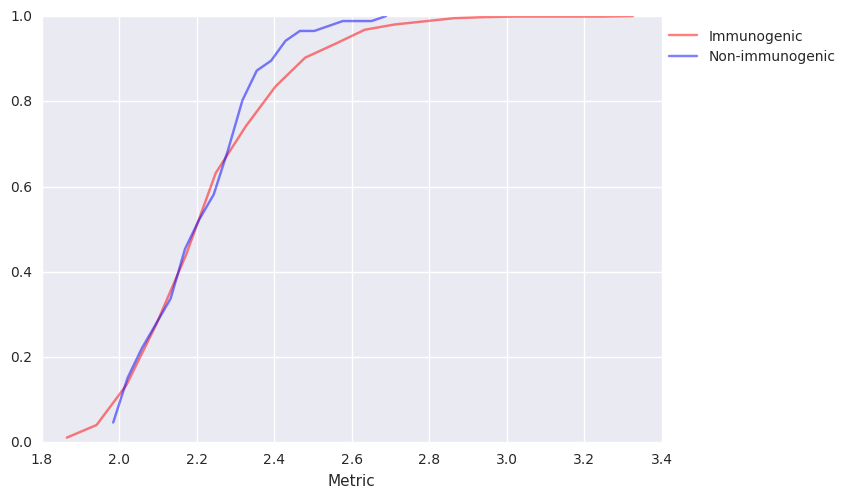

In [11]:
values, base = np.histogram(dist, bins=20, density=True)
cumulative = np.cumsum(values)
values1, base1 = np.histogram(dist1, bins=20, density=True)
cumulative1 = np.cumsum(values1)
plt.plot(base[:-1], cumulative/cumulative[-1], alpha=0.5, color='r', label='Immunogenic')
plt.plot(base1[:-1], cumulative1/cumulative1[-1], alpha=0.5, color='b', label='Non-immunogenic')
plt.legend(bbox_to_anchor=[1.3, 1])
plt.xlabel("Metric")

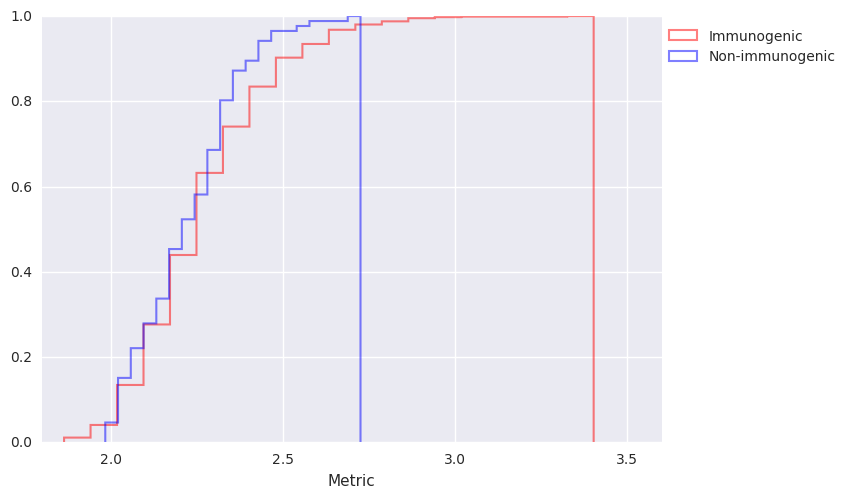

In [59]:
plt.hist(dist, bins=20, normed=True, cumulative=True, linewidth=1.5,
         histtype='step', alpha=0.5, color='r', label='Immunogenic')
plt.hist(dist1, bins=20, normed=True, cumulative=True, linewidth=1.5,
         histtype='step', alpha=0.5, color='b', label='Non-immunogenic')
plt.legend(bbox_to_anchor=[1.3, 1])
plt.xlabel("Metric")

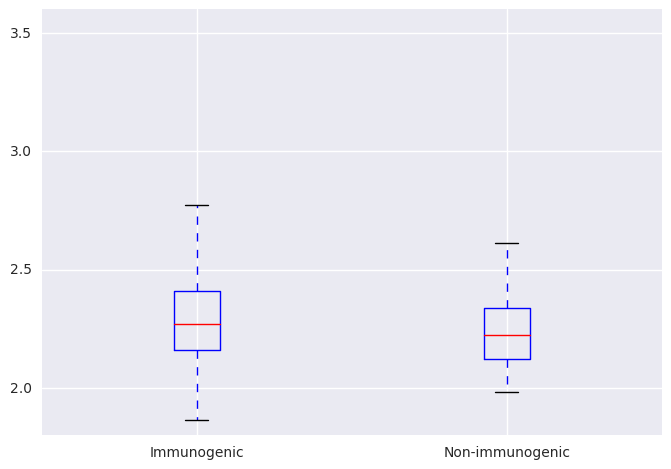

In [79]:
plt.boxplot([dist, dist1], labels=['Immunogenic', 'Non-immunogenic']);

In [ ]:
cores = mp.cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want

class Immunodistance:
    
    def __init__(self, hla, percent, immunogenicity, idf, pdf):
        self.percent = percent    
        self.idf = idf[(idf['Immunogenicity']==immunogenicity)&(idf['MHC']==hla)][features].values
        self.pdf = pdf[features].values
    
    def distance(self, inds):
        return np.linalg.norm(self.idf[inds[0],:] - self.pdf[inds[1],:])

    def count_dist(self):
        dist = []
        percent = self.percent/100
        with mp.Pool(cores) as pool:
            for j in trange(len(self.idf)):
                imres = np.array(pool.map(self.distance, [(j, i) for i in range(len(self.pdf))]))
                top_ind = np.argpartition(imres, -np.int(len(self.pdf)*percent))[-np.int(len(self.pdf)*percent):]
                dist.append(imres[top_ind].mean())
        return dist
# This code doesn't work right - it takes 40 minutes for an iteration

A0201di = Immunodistance('HLA-A*02:01', 10, 1, idf, pdf)
A0201immdist = A0201di.count_dist()
A0201di = count_dist('HLA-A*02:01', 1, 10)
A0201dn = count_dist('HLA-A*02:01', 0, 10)